In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth, Rescale_sfh, lbt_to_z, boot_to_posterior, age_to_z, Posterior_spec
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
alldb = pd.read_pickle('../dataframes/fitdb/allfits_1D.pkl')
bspec = [27458,294464,36348,48631,19290,32566,32691,33093,26272,35640,45333, 30144]
nog102 = [27714,37189,26139,32799,47223,22774,28890,23073,31452,24033]

inout = []
for i in alldb.index:     
    if alldb.id[i] not in bspec and alldb.id[i] not in nog102: 
        inout.append('i')
    else:
        inout.append('o')
        
alldb['inout'] = inout

# alldb = alldb.query('inout == "i"')

mdb = alldb.query('inout == "i" and 0.7 < zgrism < 2.5 and Sigma1 > 10**9.6 and W_UVJ == "Q" and \
                     AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20')

In [3]:
len(mdb.AGN.values)

99

In [8]:
GSD_X = Table.read('../data/clear_gdsxray.dat', format = 'ascii').to_pandas()
GND_X = Table.read('../data/clear_gdnxray.dat', format = 'ascii').to_pandas()

In [4]:
# GSD_X = GSD_X.query('Xclass == "AGN"')
# GND_X = GND_X.query('Xclass == "AGN"')

In [15]:
GND_X.query('ID == 16758')

,ID,log(Xflux),log(Xlum),Xclass
751,16758,-99.0,-99.0,-
3909,16758,-99.0,-99.0,-


In [25]:
AGN = []
for i in morph_db.index:
    if morph_db.field[i] == 'GND':
        AGN.append(GND_X.query('ID == {}'.format(morph_db.id[i])).Xclass.values[0])
    else:
        AGN.append(GSD_X.query('ID == {}'.format(morph_db.id[i])).Xclass.values[0])


In [26]:
morph_db['AGN'] = AGN

In [27]:
morph_db.to_pickle('../dataframes/fitdb/fullfitdb.pkl')

In [28]:
morph_db

,Av,Av_hci,Av_modality,Z,Z_hci,Z_modality,lmass,lmass_hci,lmass_modality,lwa,...,Re_sig,A,B,Sigma1,compact_A,compact_B,compact_Sigma1,n,n_f,AGN
0,0.270719,"[0.16922023342214415, 0.3580560675700637]",[0.0],0.753571,"[0.6427262520689969, 0.8671865202330316]",[0.0],10.797066,"[10.770714354486511, 10.821257505720784]",[0.0],1.417300,...,0.049158,2.825429,10.348740,7.814666e+09,e,c,c,5.2010,1,-
1,0.135490,"[0.07759983419713681, 0.22743261995240213]",[0.05991302745894009],1.417713,"[1.1944661848436977, 1.577536811960061]",[0.10492619574413169],10.864415,"[10.837165363620215, 10.88423375909862]",[0.0],2.711068,...,0.047496,3.240035,10.251124,8.156996e+09,e,e,c,5.2583,1,-
2,0.171519,"[0.11569269961542136, 0.2413008041752247]",[0.0],0.894623,"[0.6516357102494938, 0.9647152625060016]",[0.0],10.465980,"[10.44008321536899, 10.50482517507497]",[0.0],2.714860,...,0.081943,6.872733,9.811058,4.011537e+09,e,e,c,8.0000,2,-
3,0.005068,"[0.0011661896663650536, 0.009293930123635582]",[0.0],0.991763,"[0.9122671008283152, 1.097094323705967]",[0.0],11.015592,"[10.988143970307299, 11.037892807435993]",[0.0],3.639914,...,0.027585,1.729039,10.641344,1.372625e+10,c,c,c,5.1055,1,-
4,0.001471,"[0.0014707817236648646, 0.01739946409891359]",[0.0],0.823995,"[0.7544230763540225, 1.042650243255692]",[0.0],10.575848,"[10.552230186245742, 10.59651412569902]",[0.3868511423452635],1.992188,...,0.047046,6.051406,9.880234,5.180422e+09,e,e,c,8.0000,2,-
5,0.002251,"[0.00225108705715933, 0.019414927062710877]",[0.0],1.301842,"[1.2292647132981889, 1.442159500213116]",[0.0],10.787139,"[10.773405537133566, 10.799543179003244]",[0.0],2.763909,...,0.084218,2.186744,10.516911,8.554305e+09,c,c,c,3.7792,0,-
6,0.002015,"[0.0020145302202840693, 0.052519956693499695]",[0.0],1.164521,"[1.0499960901924643, 1.3935702529148686]",[0.6119482218326805],10.254916,"[10.206523417059142, 10.278379447279498]",[0.20469405377988364],2.229119,...,0.092628,7.565348,9.774892,2.889749e+09,e,e,e,8.0000,2,-
7,0.563701,"[0.512329566425902, 0.6222407649997757]",[0.0],0.642978,"[0.5184121410611915, 0.7980493166267904]",[0.0],10.978642,"[10.934452175895153, 11.012366242734007]",[0.0],2.449595,...,0.016833,1.509159,10.734567,1.167988e+10,c,c,c,2.1054,1,-
8,0.001553,"[0.0015527535596045338, 0.020233460014779187]",[3.5406719313472395],0.997337,"[0.8417556959571767, 1.0559985282008886]",[0.6478934330500922],11.154570,"[11.124766866079527, 11.179050965228331]",[0.0],2.957787,...,0.025098,0.633636,11.277919,2.291629e+10,c,c,c,2.5538,1,-
9,0.001461,"[0.0014613948810399337, 0.05211225821095711]",[0.0],0.770235,"[0.6613905628015446, 0.9829769697468576]",[0.45212105138124165],10.332417,"[10.298292104932647, 10.356505913551764]",[0.0],2.233225,...,0.078445,3.460780,10.274687,3.775844e+09,e,e,c,4.6861,0,-


In [6]:
all_phot = glob('../phot/*npy')

In [7]:
fields = [os.path.basename(U).split('_')[0] for U in all_phot]
galaxy = [int(os.path.basename(U).split('_')[1]) for U in all_phot]


In [8]:
IDS = morph_db.id.values

outgals = []
outfields = []
for i in range(len(galaxy)):
    if galaxy[i] not in IDS:
        outgals.append(galaxy[i])
        outfields.append(fields[i])

In [9]:
IDS = GND_X.ID.values

for i in range(len(outfields)):
    if outfields[i][1] == 'N':
        if outgals[i] not in IDS:
            print(outgals[i])
print('=============')           
            
IDS = GSD_X.ID.values

for i in range(len(outfields)):
    if outfields[i][1] == 'S':
        if outgals[i] in IDS:
            print(outgals[i])

21618
22571
14132
14970
21427
11814
33780
36161
26544
12543
37343
37065
24863
11245
21896
22184
37765
17735
37281
22633
31397
42113
44725
42915
38472
35046
41886
39364
43114
23421
42820
39825
25641
42778
26915


In [10]:
GNSNR = pd.read_pickle('../dataframes/galaxy_frames/GN_cnd.pkl')
GSSNR = pd.read_pickle('../dataframes/galaxy_frames/GS_cnd.pkl')

In [11]:
IDS = GND_X.ID.values

for i in GNSNR.index:
    if GNSNR.id[i] not in IDS and GNSNR.X_AGN[i] == 'AGN':
        print(GNSNR.id[i], GNSNR.X_AGN[i])
        
    if GNSNR.id[i] in IDS and GNSNR.X_AGN[i] == '---':
        print(GNSNR.id[i], GNSNR.X_AGN[i])
print('=============')           
            
IDS = GSD_X.ID.values

for i in GSSNR.index:
    if GSSNR.id[i] not in IDS and GSSNR.X_AGN[i] == 'AGN':
        print(GSSNR.id[i], GSSNR.X_AGN[i])
        
    if GSSNR.id[i] in IDS and GSSNR.X_AGN[i] == '---':
        print(GSSNR.id[i], GSSNR.X_AGN[i])

14140 ---
23104 ---
35469 ---
37232 ---
37813 ---
29928 AGN
30144 AGN
45789 ---


# plot phots

In [4]:
def Roll_bin_stat(X,Y,E,bin_size):
    W = 1/E ** 2
    Y = Y[np.argsort(X)]
    W = W[np.argsort(X)]
    X = X[np.argsort(X)]
    
    X_med = [] ; X_mean = [] ; binned_median = [] ; binned_wmean = [] ; binned_err = []

    i=0
    low_lim = X[i]
    while low_lim < max(X):
        IDX = [U for U in range(len(X)) if low_lim <= X[U] < low_lim + bin_size]
        X_med.append(np.median(X[IDX]))
        X_mean.append(np.median(low_lim + bin_size / 2))
        binned_median.append(np.median(Y[IDX]))
        binned_wmean.append(np.sum(Y[IDX] * W[IDX]) / (np.sum(W[IDX])))
        binned_err.append(1 / np.sqrt(np.sum(W[IDX])))
        i+=1
        low_lim = X[i]
    return np.array(X_med), np.array(X_mean), np.array(binned_median), np.array(binned_wmean) , np.array(binned_err)

def Smooth(x,f,bw):
    ksmooth = importr('KernSmooth')

    ### select bandwidth
    H = ksmooth.dpik(x)
    
    if bw == 'none':
        bw = H
    
    fx = ksmooth.locpoly(x,f,bandwidth = bw)
    X = np.array(fx[0])
    iFX = np.array(fx[1])
    return interp1d(X,iFX)(x)

In [5]:
zlim = 2.9

In [6]:
PWV1 = []
PER1 = []
PFL1 = []

for ID in mdb.query('z_50 < {} and 0.9 < zgrism < 1.1'.format(zlim)).index:
    pwv,pfl,per,pnum = np.load('../phot/{0}_{1}_phot.npy'.format(mdb.field[ID], mdb.id[ID]))
    
    pwv = pwv[pfl > 0] 
    per = per[pfl > 0] 
    pfl = pfl[pfl > 0]
    
    pfl = pfl[np.argsort(pwv)]
    per = per[np.argsort(pwv)]
    pwv = pwv[np.argsort(pwv)]
        
    norm = np.trapz(pfl,pwv/ (1 +mdb.zgrism[ID] ))
    
    PWV1.extend(pwv / (1 +mdb.zgrism[ID] ))
    PER1.extend(per/norm)
    PFL1.extend(pfl/norm)
    
PWV1 = np.array(PWV1)
PFL1 = np.array(PFL1)
PER1 = np.array(PER1)

PWV2 = []
PER2 = []
PFL2 = []

for ID in mdb.query('z_50 > {} and  0.9 < zgrism < 1.1'.format(zlim)).index:
    pwv,pfl,per,pnum = np.load('../phot/{0}_{1}_phot.npy'.format(mdb.field[ID], mdb.id[ID]))
    
    pwv = pwv[pfl > 0] 
    per = per[pfl > 0] 
    pfl = pfl[pfl > 0]
    
    pfl = pfl[np.argsort(pwv)]
    per = per[np.argsort(pwv)]
    pwv = pwv[np.argsort(pwv)]
        
    norm = np.trapz(pfl,pwv/ (1 +mdb.zgrism[ID] ))
    
    PWV2.extend(pwv / (1 +mdb.zgrism[ID] ))
    PER2.extend(per/norm)
    PFL2.extend(pfl/norm)
    
PWV2 = np.array(PWV2)
PFL2 = np.array(PFL2)
PER2 = np.array(PER2)

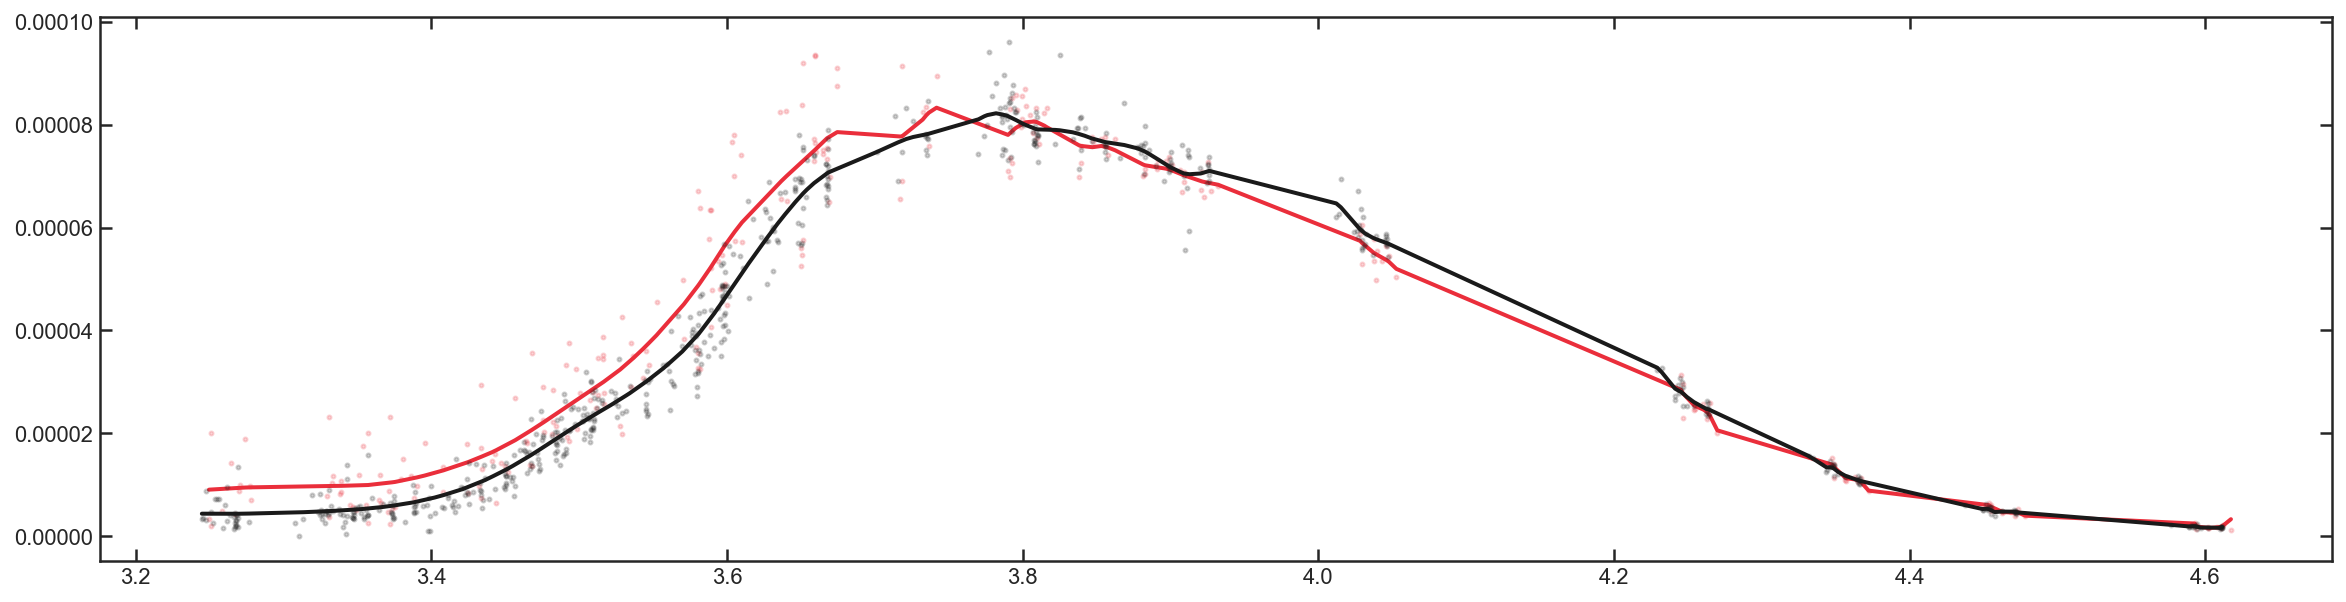

In [7]:
plt.figure(figsize=[20,5])


plt.plot(np.log10(PWV1),PFL1, 'o', ms=2, color='#EA2E3B', zorder = 2, alpha = 0.2)
plt.plot(np.log10(PWV1[np.argsort(PWV1)]),Smooth(PWV1[np.argsort(PWV1)],PFL1[np.argsort(PWV1)],200), color='#EA2E3B', linewidth = 2)

plt.plot(np.log10(PWV2),PFL2, 'o', ms=2, color='k', zorder = 2, alpha = 0.2)
plt.plot(np.log10(PWV2[np.argsort(PWV2)]),Smooth(PWV2[np.argsort(PWV2)],PFL2[np.argsort(PWV2)],200), 'k', linewidth = 2)

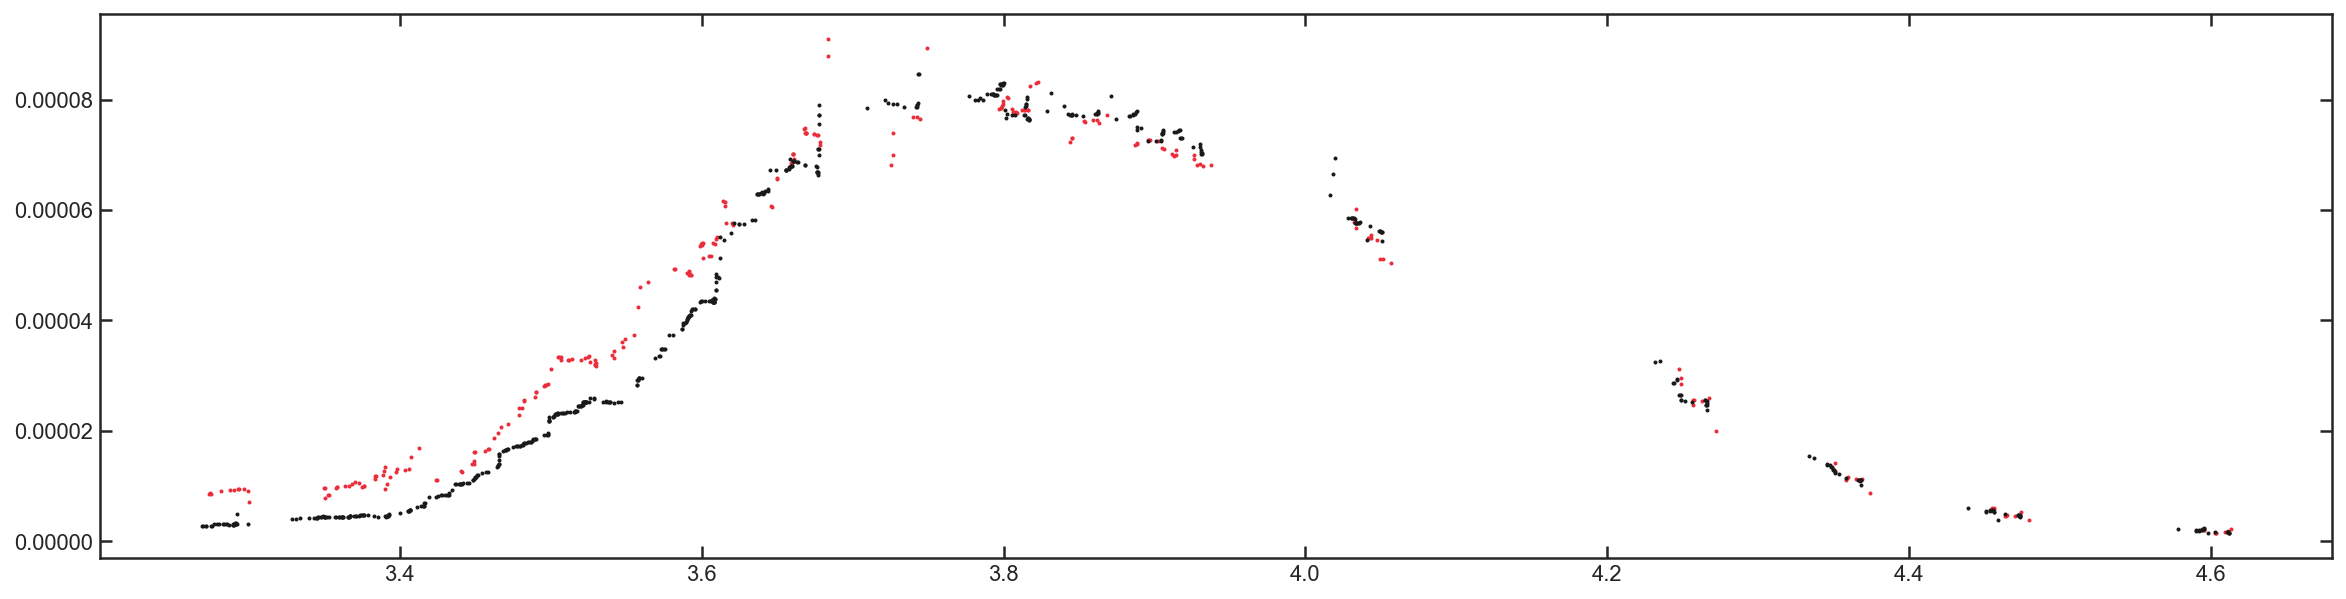

In [8]:
wmed1,wmn1,pmed1,pmn1,perr1 = Roll_bin_stat(PWV1,PFL1,PER1, bin_size=200)
wmed2,wmn2,pmed2,pmn2,perr2 = Roll_bin_stat(PWV2,PFL2,PER2, bin_size=200)

plt.figure(figsize=[20,5])

plt.plot(np.log10(wmn1),pmn1, 'o', color='#EA2E3B', ms = 1)
plt.plot(np.log10(wmn2),pmn2,  'o', color='k', ms = 1)

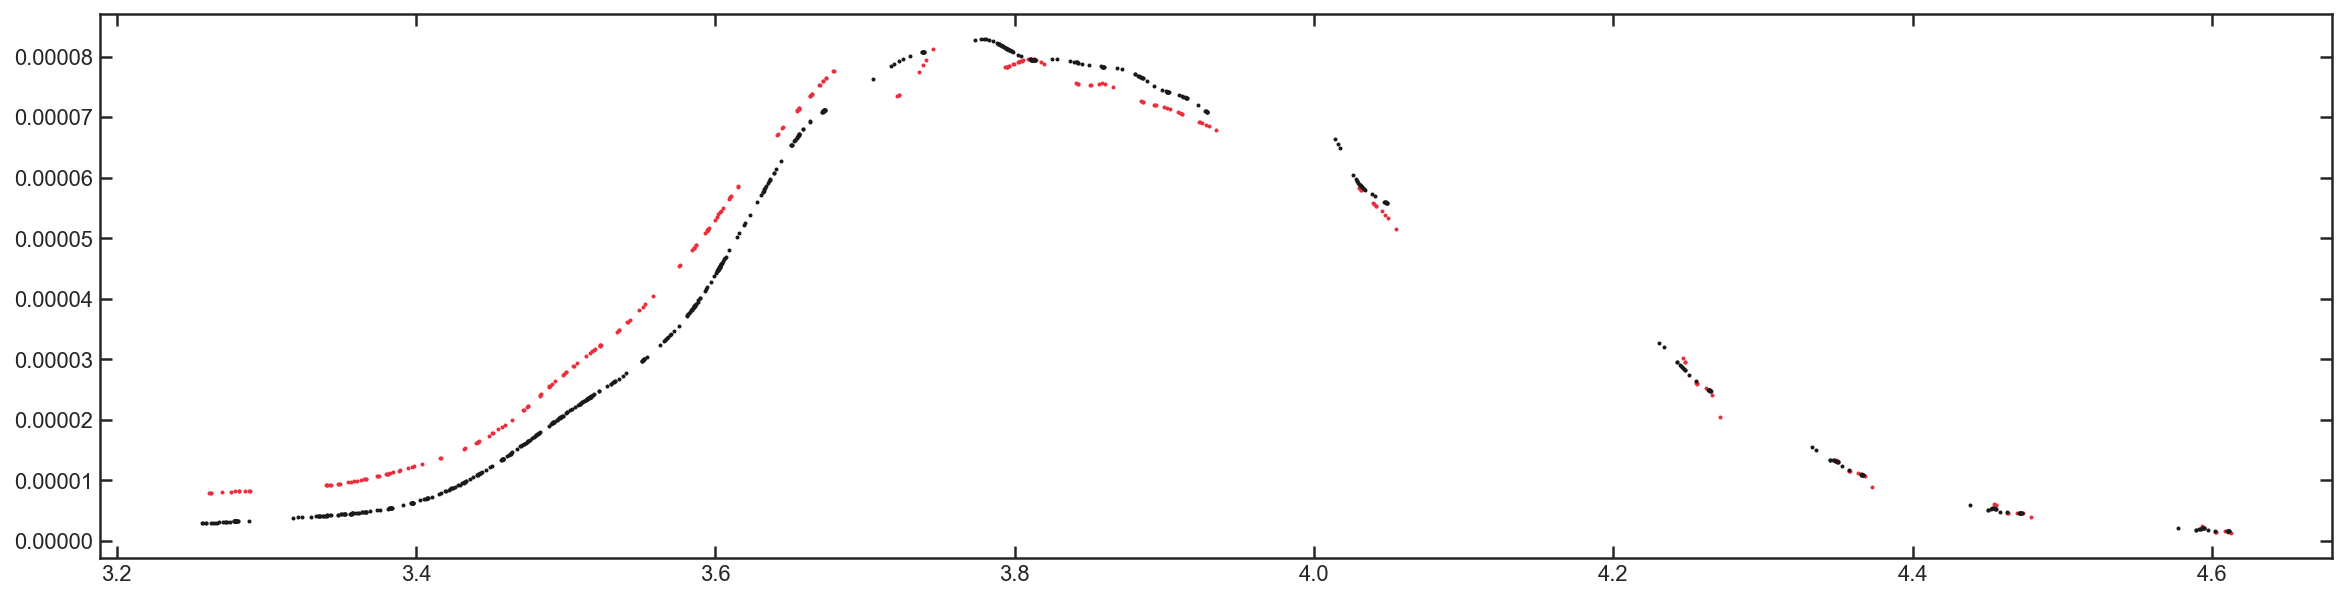

In [9]:
wmed1,wmn1,pmed1,pmn1,perr1 = Roll_bin_stat(PWV1,PFL1,PER1, bin_size=100)
wmed2,wmn2,pmed2,pmn2,perr2 = Roll_bin_stat(PWV2,PFL2,PER2, bin_size=100)

plt.figure(figsize=[20,5])

plt.plot(np.log10(wmn1),Smooth(wmn1,pmn1,200), 'o', color='#EA2E3B', ms = 1)
plt.plot(np.log10(wmn2),Smooth(wmn2,pmn2,200),  'o', color='k', ms = 1)
# plt.xlim(3.2,4)
# plt.ylim(-14.5,-8)

In [48]:
np.median(mdb.z_50)

3.382422792172372

In [13]:
flxgrid = []
errgrid = []
swave = np.arange(3000,8000,10)

for i in mdb.query('z_50 > {} and 0.9 < zgrism < 1.1'.format(zlim)).index:
    field = mdb.field[i]
    galaxy = mdb.id[i]

    m, a, m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, lm, z, d, \
    bp1, rp1, ba, bb, bl, ra, rb, rl, lwa, logl = np.load(
        '../data/bestfits/{0}_{1}_tabfit_bfit.npy'.format(field, galaxy))

    Gs = Gen_spec(field, galaxy, z, phot_errterm = 0.04, irac_err = 0.08) 

    wvs, flxs, errs, beams, trans = Gather_grism_data(Gs)

    sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
    sp.params['dust2'] = d
    sp.params['dust1'] = d
    sp.params['logzsol'] = np.log10(m)

    time, sfr, tmax = convert_sfh(get_agebins(a), [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10], maxage = a*1E9)

    sp.set_tabular_sfh(time,sfr)    

    wave, flux = sp.get_spectrum(tage = a, peraa = True)    

    Gmfl, Pmfl = Full_forward_model(Gs, wave, F_lam_per_M(flux,wave*(1+z),z,0,sp.stellar_mass)*10**lm, z, 
                                    wvs, flxs, errs, beams, trans)

    MFLX = F_lam_per_M(flux,wave*(1+z),z,0,sp.stellar_mass)*10**lm

    IDX = [U for U in range(len(wave)) if 6000 < wave[U] < 6500]

    Nfact = np.trapz(MFLX[IDX],wave[IDX])

    sidx = 0
    sflux = np.zeros(len(swave))
    serror = np.zeros(len(swave))

    if Gs.g102:
        bcal = Calibrate_grism([wvs[sidx], flxs[sidx], errs[sidx]], Gmfl[sidx], bp1)[0]
        bscale = Scale_model( flxs[sidx] / bcal,errs[sidx]/ bcal,Gmfl[sidx])
        iBflx =interp1d(Gs.Bwv_rf,flxs[sidx] / bcal/ bscale / Nfact, fill_value=0, bounds_error=False)(swave)
        iBerr =interp1d(Gs.Bwv_rf,errs[sidx] / bcal/ bscale / Nfact, fill_value=0, bounds_error=False)(swave)
        sflux += iBflx
        serror += iBerr

        sidx += 1

    if Gs.g141:
        rcal = Calibrate_grism([wvs[sidx], flxs[sidx], errs[sidx]], Gmfl[sidx], rp1)[0]
        rscale =Scale_model( flxs[sidx] / rcal,errs[sidx]/ rcal,Gmfl[sidx])
        iRflx =interp1d(Gs.Rwv_rf,flxs[sidx] / rcal/ rscale / Nfact, fill_value=0, bounds_error=False)(swave)
        iRerr =interp1d(Gs.Rwv_rf,errs[sidx] / rcal/ rscale / Nfact, fill_value=0, bounds_error=False)(swave)
        sflux += iRflx
        serror += iRerr

    serror[serror == 0] = 1E5

    flxgrid.append(sflux)
    errgrid.append(serror)        

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3558: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3559: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))


1 icat21cfq_flt.fits G102
2 icat21coq_flt.fits G102
3 icat21dgq_flt.fits G102
4 icat21dlq_flt.fits G102
5 icxt55krq_flt.fits G102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


6 icxt55ksq_flt.fits G102
7 icxt55kvq_flt.fits G102
8 icxt55kxq_flt.fits G102
9 icxta4mdq_flt.fits G102
10 icxta4meq_flt.fits G102
11 icxta4mhq_flt.fits G102
12 icxta4mjq_flt.fits G102
13 icxt52i0q_flt.fits G102
14 icxt52i1q_flt.fits G102
15 icxt52i4q_flt.fits G102
16 icxt52i6q_flt.fits G102
17 icxt53i9q_flt.fits G102
18 icxt53iaq_flt.fits G102
19 icxt53idq_flt.fits G102
20 icxt53ifq_flt.fits G102
21 icxt51jvq_flt.fits G102
22 icxt51jwq_flt.fits G102
23 icxt51jzq_flt.fits G102
24 icxt51k1q_flt.fits G102
25 ib3721xiq_flt.fits G141
26 ib3721xmq_flt.fits G141
27 ib3721xyq_flt.fits G141
28 ib3721y2q_flt.fits G141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  se

1 icat21cfq_flt.fits G102
2 icat21coq_flt.fits G102
3 icat21dgq_flt.fits G102
4 icat21dlq_flt.fits G102
5 icxt55krq_flt.fits G102
6 icxt55ksq_flt.fits G102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


7 icxt55kvq_flt.fits G102
8 icxt55kxq_flt.fits G102
9 icxta4mdq_flt.fits G102
10 icxta4meq_flt.fits G102
11 icxta4mhq_flt.fits G102
12 icxta4mjq_flt.fits G102
13 icxt52i0q_flt.fits G102
14 icxt52i1q_flt.fits G102
15 icxt52i4q_flt.fits G102
16 icxt52i6q_flt.fits G102
17 icxt53i9q_flt.fits G102
18 icxt53iaq_flt.fits G102
19 icxt53idq_flt.fits G102
20 icxt53ifq_flt.fits G102
21 icxt51jvq_flt.fits G102
22 icxt51jwq_flt.fits G102
23 icxt51jzq_flt.fits G102
24 icxt51k1q_flt.fits G102
25 ib3721xiq_flt.fits G141
26 ib3721xmq_flt.fits G141
27 ib3721xyq_flt.fits G141
28 ib3721y2q_flt.fits G141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  se

1 icxt20f7q_flt.fits G102
2 icxt20f8q_flt.fits G102
3 icxt20fbq_flt.fits G102
4 icxt20fdq_flt.fits G102
5 icxt21b7q_flt.fits G102
6 icxt21b8q_flt.fits G102
7 icxt21bcq_flt.fits G102
8 icxt21beq_flt.fits G102
9 icxt19o6q_flt.fits G102
10 icxt19o7q_flt.fits G102
11 icxt19oaq_flt.fits G102
12 icxt19ocq_flt.fits G102
13 icxt22pmq_flt.fits G102
14 icxt22pnq_flt.fits G102
15 icxt22pqq_flt.fits G102
16 icxt22psq_flt.fits G102
17 icxt23pvq_flt.fits G102
18 icxt23pwq_flt.fits G102
19 icxt23pzq_flt.fits G102
20 icxt23q1q_flt.fits G102
21 ibhj23sxq_flt.fits G141
22 ibhj23t4q_flt.fits G141
23 ibhj23tbq_flt.fits G141
24 ibhj23tiq_flt.fits G141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  se

1 icxt20f7q_flt.fits G102
2 icxt20f8q_flt.fits G102
3 icxt20fbq_flt.fits G102
4 icxt20fdq_flt.fits G102
5 icxt21b7q_flt.fits G102
6 icxt21b8q_flt.fits G102
7 icxt21bcq_flt.fits G102
8 icxt21beq_flt.fits G102
9 icxt19o6q_flt.fits G102
10 icxt19o7q_flt.fits G102
11 icxt19oaq_flt.fits G102
12 icxt19ocq_flt.fits G102
13 icxt22pmq_flt.fits G102
14 icxt22pnq_flt.fits G102
15 icxt22pqq_flt.fits G102
16 icxt22psq_flt.fits G102
17 icxt23pvq_flt.fits G102
18 icxt23pwq_flt.fits G102
19 icxt23pzq_flt.fits G102
20 icxt23q1q_flt.fits G102
21 ibhj23sxq_flt.fits G141
22 ibhj23t4q_flt.fits G141
23 ibhj23tbq_flt.fits G141
24 ibhj23tiq_flt.fits G141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  se

FileNotFoundError: [Errno 2] No such file or directory: '../data/bestfits/GSD_29928_tabfit_bfit.npy'

In [11]:
def Stack(wv, flxgrid , errgrid):
    flgrid = np.transpose(flxgrid)
    errgrid = np.transpose(errgrid)
    weigrid = errgrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
    ################

    stack, err = np.zeros([2, len(wv)])
    for i in range(len(wv)):
        stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))        
        err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
    ################
    
    return stack, err

In [14]:
hzflux, hzerror = Stack(swave, flxgrid, errgrid)

<ErrorbarContainer object of 3 artists>

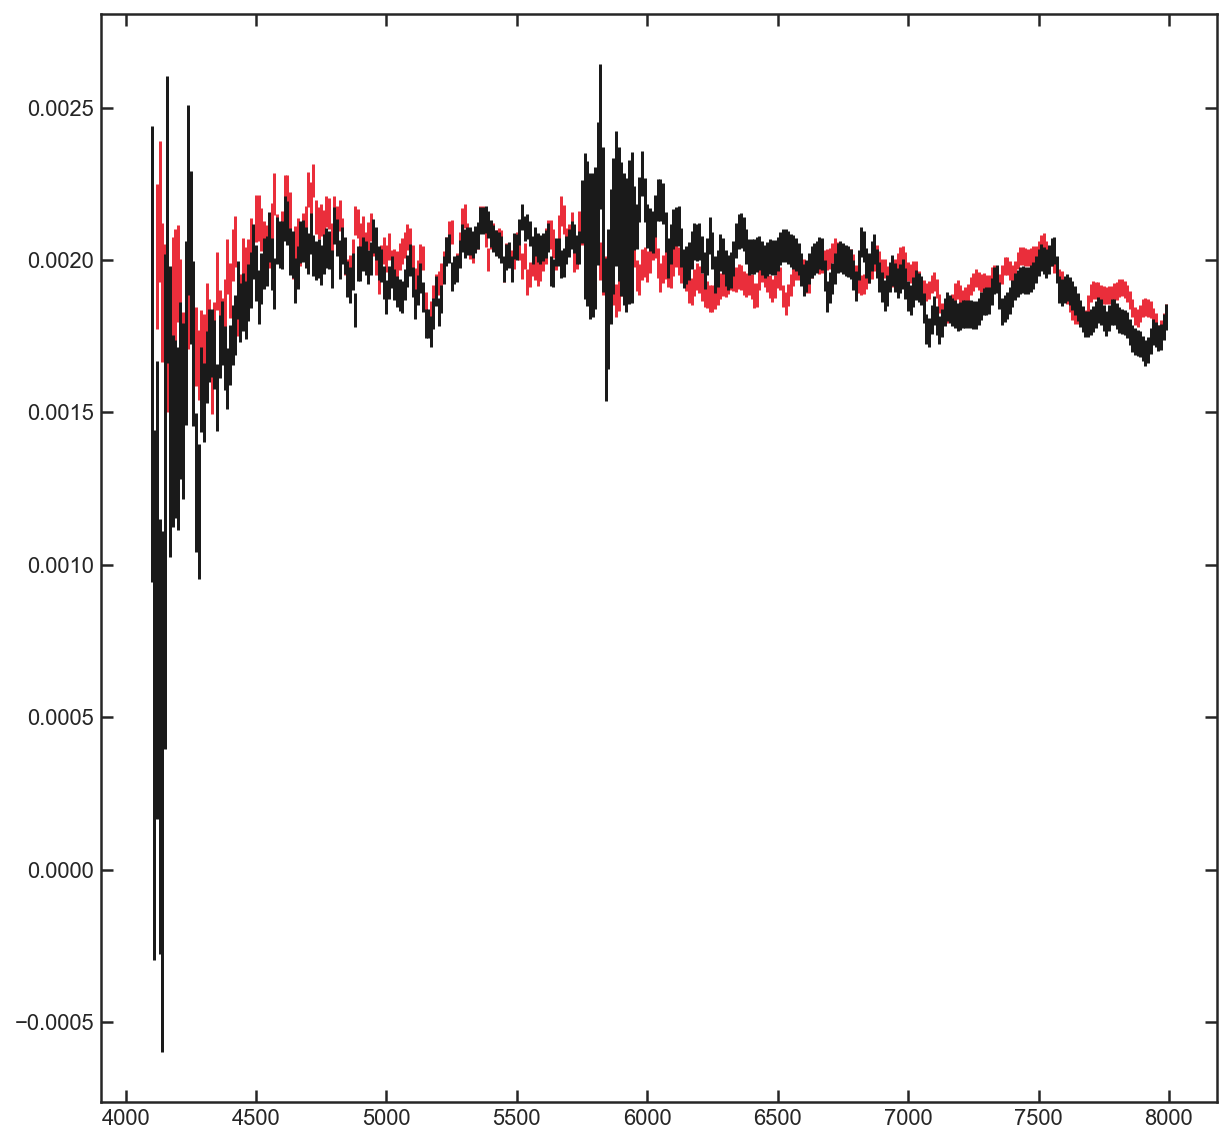

In [15]:
plt.figure(figsize=[10,10])

plt.errorbar(swave[lzflux > 0], lzflux[lzflux > 0], lzerror[lzflux > 0], linestyle = 'none', color='#EA2E3B',)
plt.errorbar(swave[hzflux > 0], hzflux[hzflux > 0], hzerror[hzflux > 0], linestyle = 'none', color='k',)

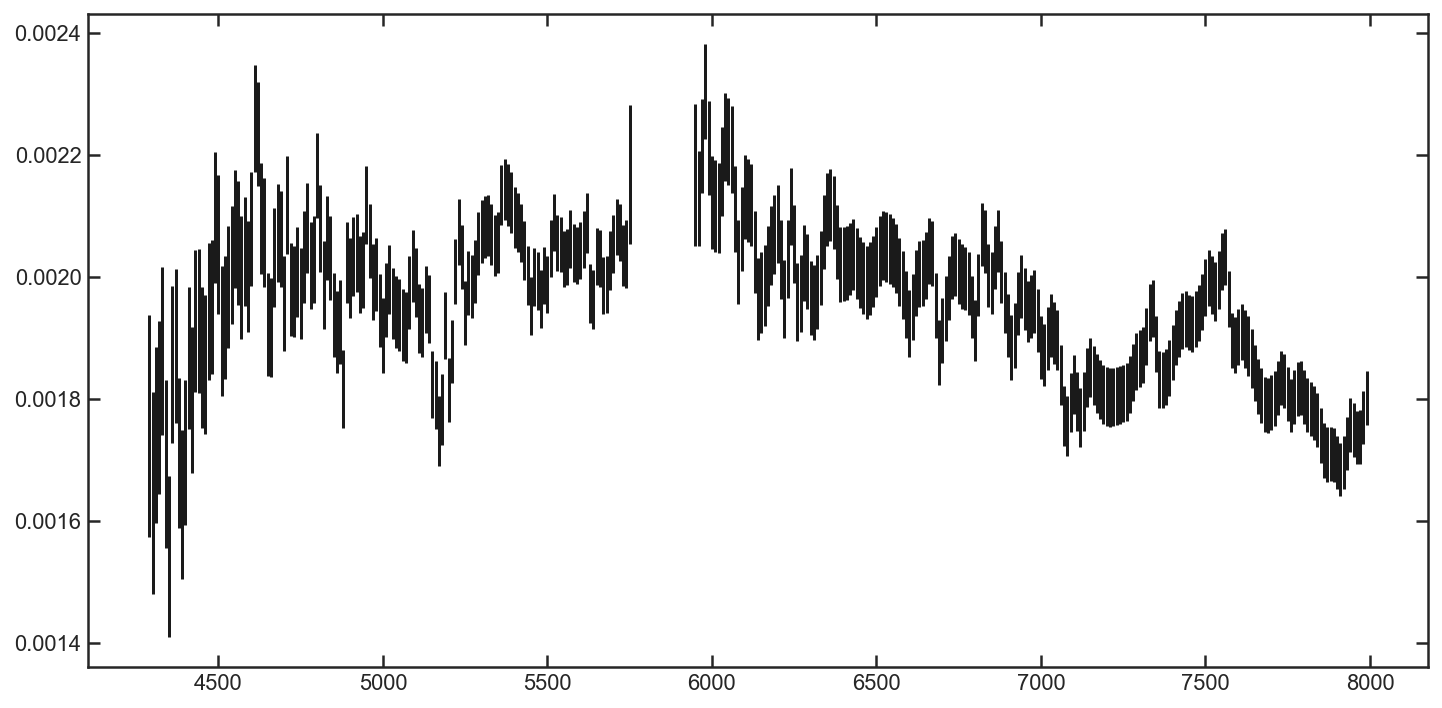

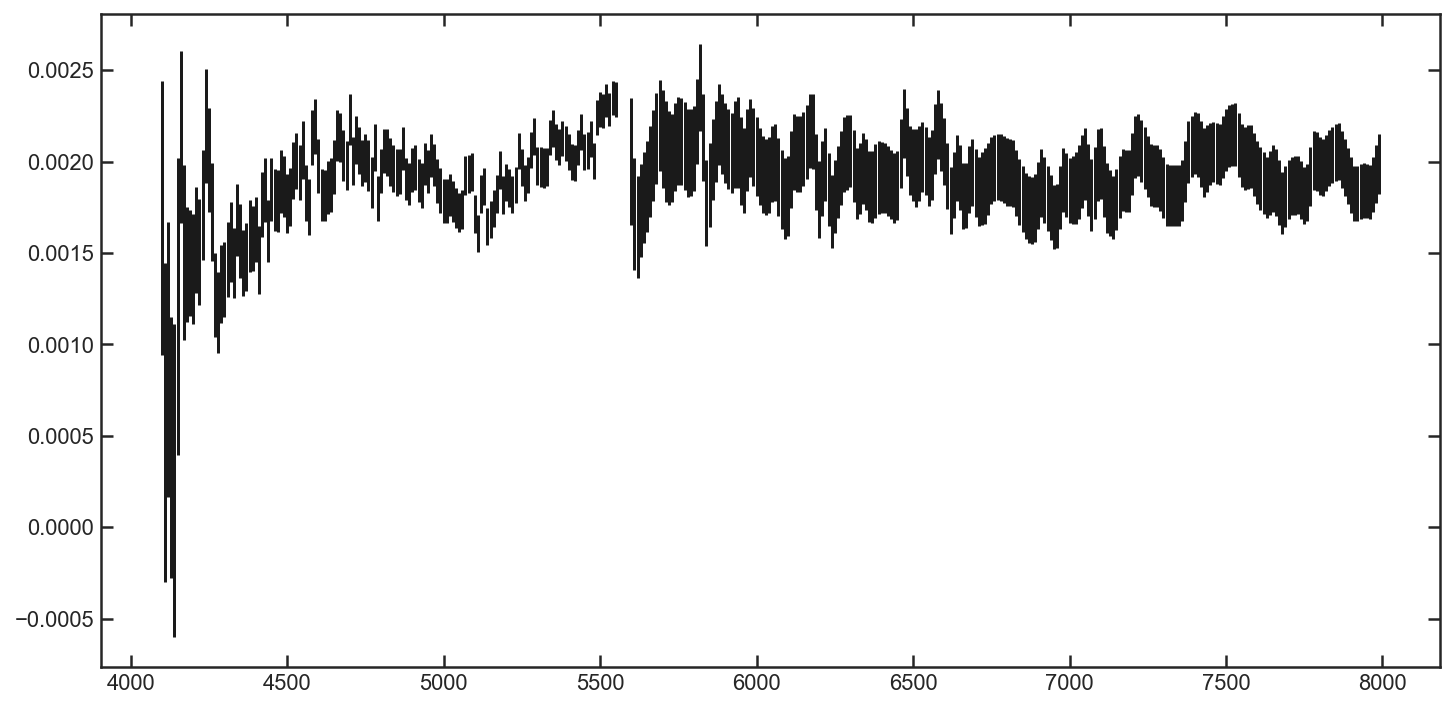

In [21]:
for i in range(len(flxgrid)):
    plt.figure(figsize=[12,6])
    plt.errorbar(swave[flxgrid[i] > 0], flxgrid[i][flxgrid[i] > 0], errgrid[i][flxgrid[i] > 0], linestyle = 'none', color='k',)

FileNotFoundError: [Errno 2] No such file or directory: '../data/SFH/GND_29183.npy'

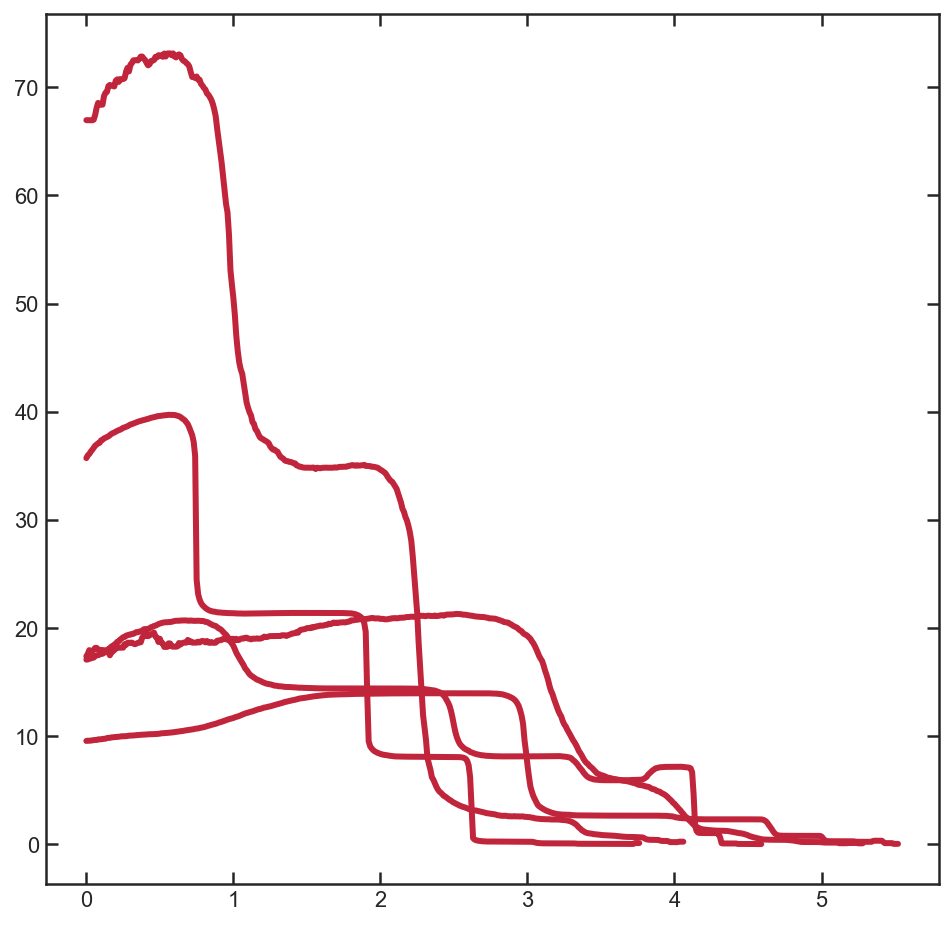

In [16]:
plt.figure(figsize =[8,8])

LBT_lz = []
SFH_lz = []
for i in mdb.query('z_50 < {} and 0.9 < zgrism < 1.1'.format(zlim)).index:
    field = mdb.field[i]
    galaxy = mdb.id[i]
    lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(field, galaxy))
    LBT_lz.append(lbt)
#     SFH_q1.append(sfh[::-1] / 10**mdb.query('z_50 > {} and Sigma1 > {}'.format(zlim,uclim)).lmass[i])
    SFH_lz.append(sfh[::-1])
    
    plt.plot(lbt, sfh[::-1], color = '#C1253C', linewidth = 3, zorder = 9)

plt.figure(figsize =[8,8])
LBT_hz = []
SFH_hz = []
for i in mdb.query('z_50 > {} and 0.9 < zgrism < 1.1'.format(zlim)).index:
    field = mdb.field[i]
    galaxy = mdb.id[i]
    lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(field, galaxy))
    LBT_hz.append(lbt)
#     SFH_q1.append(sfh[::-1] / 10**mdb.query('z_50 > {} and Sigma1 > {}'.format(zlim,uclim)).lmass[i])
    SFH_hz.append(sfh[::-1])
    
    plt.plot(lbt, sfh[::-1], color = 'k', linewidth = 3, zorder = 9)

In [16]:
def Stack_SFH(lbt, sfh):
    sfhgrid = np.transpose(sfh)
    ################

    stack = np.zeros(len(lbt))
    for i in range(len(lbt)):
        weights = len(sfhgrid[i][sfhgrid[i] > 0])
        
#         stack[i] = np.sum(sfhgrid[i]) / (weights)       
        stack[i] = np.mean(sfhgrid[i])# / (weights)        
        
    ################
    
    return stack

In [17]:
LBT = np.linspace(0,7,7000)

SFH_lzgrid = np.zeros([len(LBT_lz), len(LBT)])

for i in range(len(LBT_lz)):
    SFH_lzgrid[i] = interp1d(LBT_lz[i], SFH_lz[i], fill_value=0, bounds_error=False)(LBT)

sfh_stack_lz = Stack_SFH(LBT, SFH_lzgrid)

SFH_hzgrid = np.zeros([len(LBT_hz), len(LBT)])

for i in range(len(LBT_hz)):
    SFH_hzgrid[i] = interp1d(LBT_hz[i], SFH_hz[i], fill_value=0, bounds_error=False)(LBT)

sfh_stack_hz = Stack_SFH(LBT, SFH_hzgrid)

NameError: name 'LBT_hz' is not defined

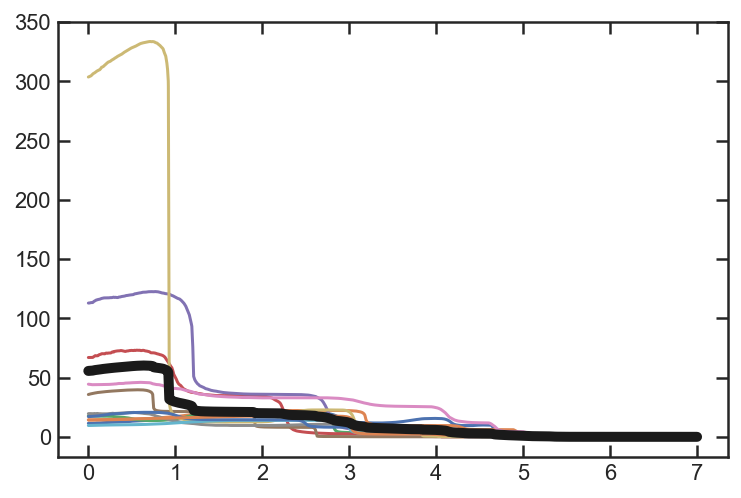

In [18]:
plt.plot(LBT, SFH_lzgrid.T)
plt.plot(LBT, sfh_stack_lz, 'k', linewidth = 5)

In [19]:
plt.plot(LBT, SFH_hzgrid.T)
plt.plot(LBT, sfh_stack_hz, 'k', linewidth = 5)

NameError: name 'SFH_hzgrid' is not defined

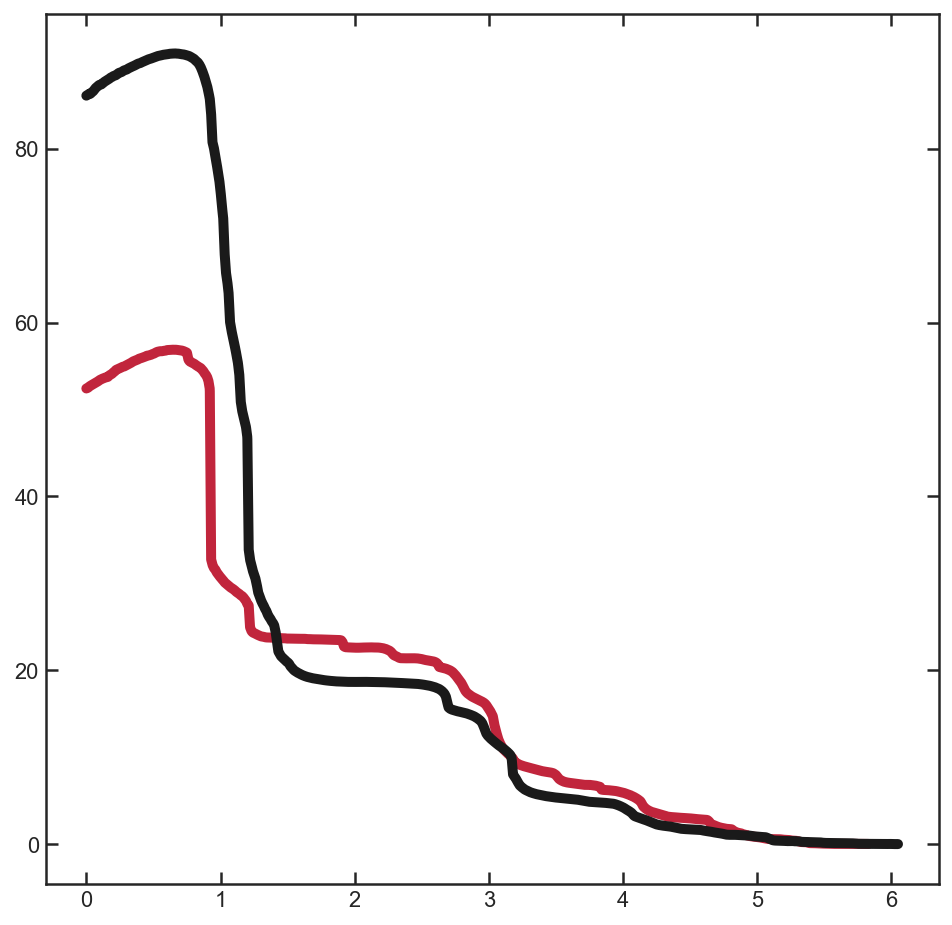

In [20]:
plt.figure(figsize =[8,8])

plt.plot(LBT[sfh_stack_lz > 0], sfh_stack_lz[sfh_stack_lz > 0], '#C1253C', linewidth = 5)
plt.plot(LBT[sfh_stack_hz > 0], sfh_stack_hz[sfh_stack_hz > 0], 'k', linewidth = 5)

No handles with labels found to put in legend.


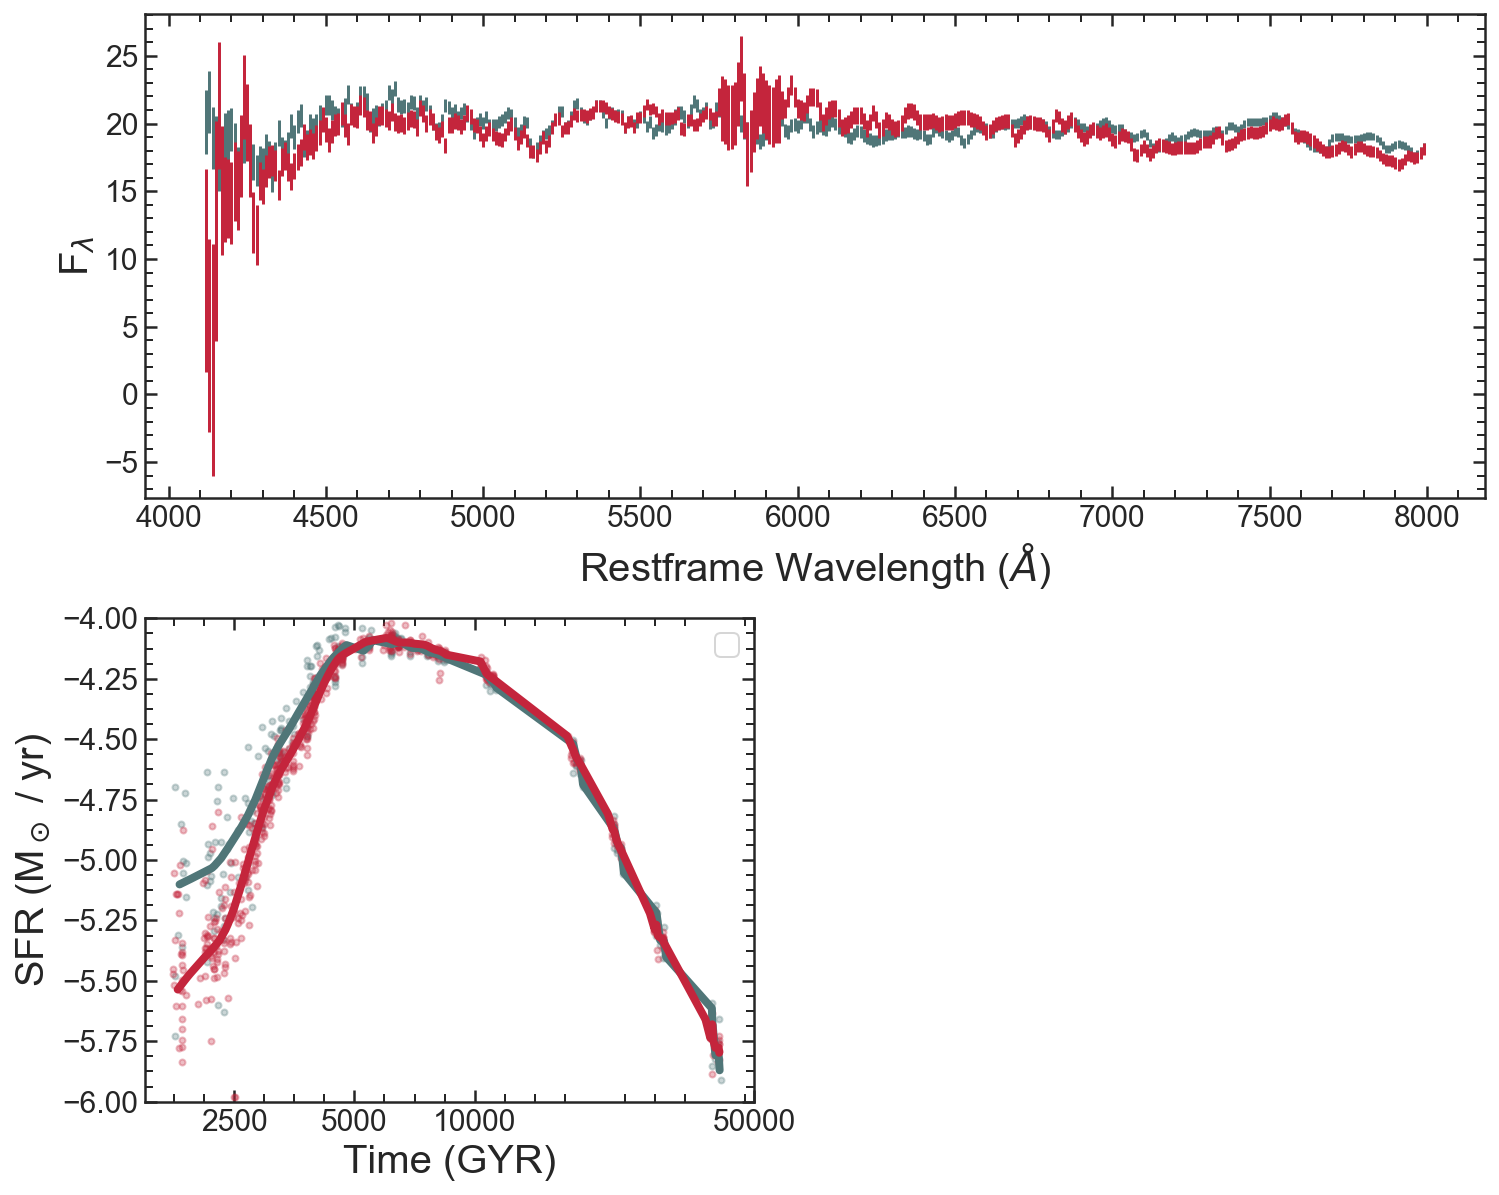

In [17]:
gs = gridspec.GridSpec(2,2,hspace=0.25,wspace=0.2)

plt.figure(figsize=[12,10])
plt.subplot(gs[0,:])
plt.errorbar(swave[swave > 4110], lzflux[swave > 4110]*1E4, lzerror[swave > 4110]*1E4,
             linestyle = 'none', color='#507678',)
plt.errorbar(swave[swave > 4110], hzflux[swave > 4110]*1E4, hzerror[swave > 4110]*1E4, 
             linestyle = 'none', color='#C4253C',)

# plt.plot(swave[swave > 4110], lzflux[swave > 4110]*1E4, color='#EA2E3B')
# plt.plot(swave[swave > 4110], hzflux[swave > 4110]*1E4, color='k')

plt.xlabel('Restframe Wavelength ($\AA$)', fontsize=20)
plt.ylabel('F$_\lambda$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
# plt.ylim(3,5)
plt.minorticks_on()

plt.subplot(gs[1,0])
plt.plot(np.log10(PWV1),np.log10(  PFL1), 'o', ms=3, color='#507678', zorder = 2, alpha = 0.3)
plt.plot(np.log10(PWV2),np.log10(  PFL2), 'o', ms=3, color='#C4253C', zorder = 2, alpha = 0.3)

plt.plot(np.log10(wmn1),np.log10(  Smooth(wmn1,pmn1,200)), color='#507678', linewidth = 4)
plt.plot(np.log10(wmn2),np.log10( Smooth(wmn2,pmn2,200)),  color='#C4253C', linewidth = 4)

# plt.xlim(3.2,3.95)
plt.ylim(-6,-4)
plt.xticks(np.log10([2500,5000,10000,50000]), [2500,5000,10000,50000])

plt.xlabel('Restframe Wavelength ($\AA$)', fontsize=20)
plt.ylabel('log(F$_\lambda$)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.minorticks_on()


# plt.subplot(gs[1,1])
# plt.plot(LBT[sfh_stack_lz > 0], sfh_stack_lz[sfh_stack_lz > 0], '#507678', linewidth = 5,label = 'z$_{50}$ < 3.3, 0.9 < z < 1.1')
# plt.plot(LBT[sfh_stack_hz > 0], sfh_stack_hz[sfh_stack_hz > 0], '#C4253C', linewidth = 5,label = 'z$_{50}$ > 3.3, 0.9 < z < 1.1')

plt.minorticks_on()

plt.xlabel('Time (GYR)', fontsize=20)
plt.ylabel('SFR (M$_\odot$ / yr)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=15)
# plt.savefig('../plots/presentation_plots/SFH_summary.png', bbox_inches = 'tight')

In [23]:
wmn1[0],wmn1[-1],wmn2[0],wmn2[-1]

(1819.5998978435307, 40925.60562221037, 1861.3782421884152, 40947.88331541105)

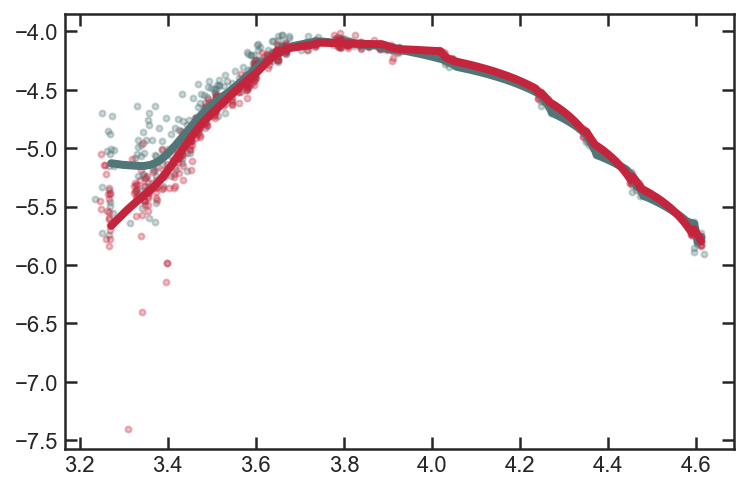

In [25]:
iwmn = np.linspace(1870,40800, 1000)
ipmn1 = interp1d(wmn1, Smooth(wmn1,pmn1,200))(iwmn)
ipmn2 = interp1d(wmn2, Smooth(wmn2,pmn2,200))(iwmn)


plt.subplot()
plt.plot(np.log10(PWV1),np.log10(PFL1), 'o', ms=3, color='#507678', zorder = 2, alpha = 0.3)
plt.plot(np.log10(PWV2),np.log10(PFL2), 'o', ms=3, color='#C4253C', zorder = 2, alpha = 0.3)

plt.plot(np.log10(iwmn),np.log10(ipmn1), color='#507678', linewidth = 4)
plt.plot(np.log10(iwmn),np.log10(ipmn2),  color='#C4253C', linewidth = 4)

No handles with labels found to put in legend.


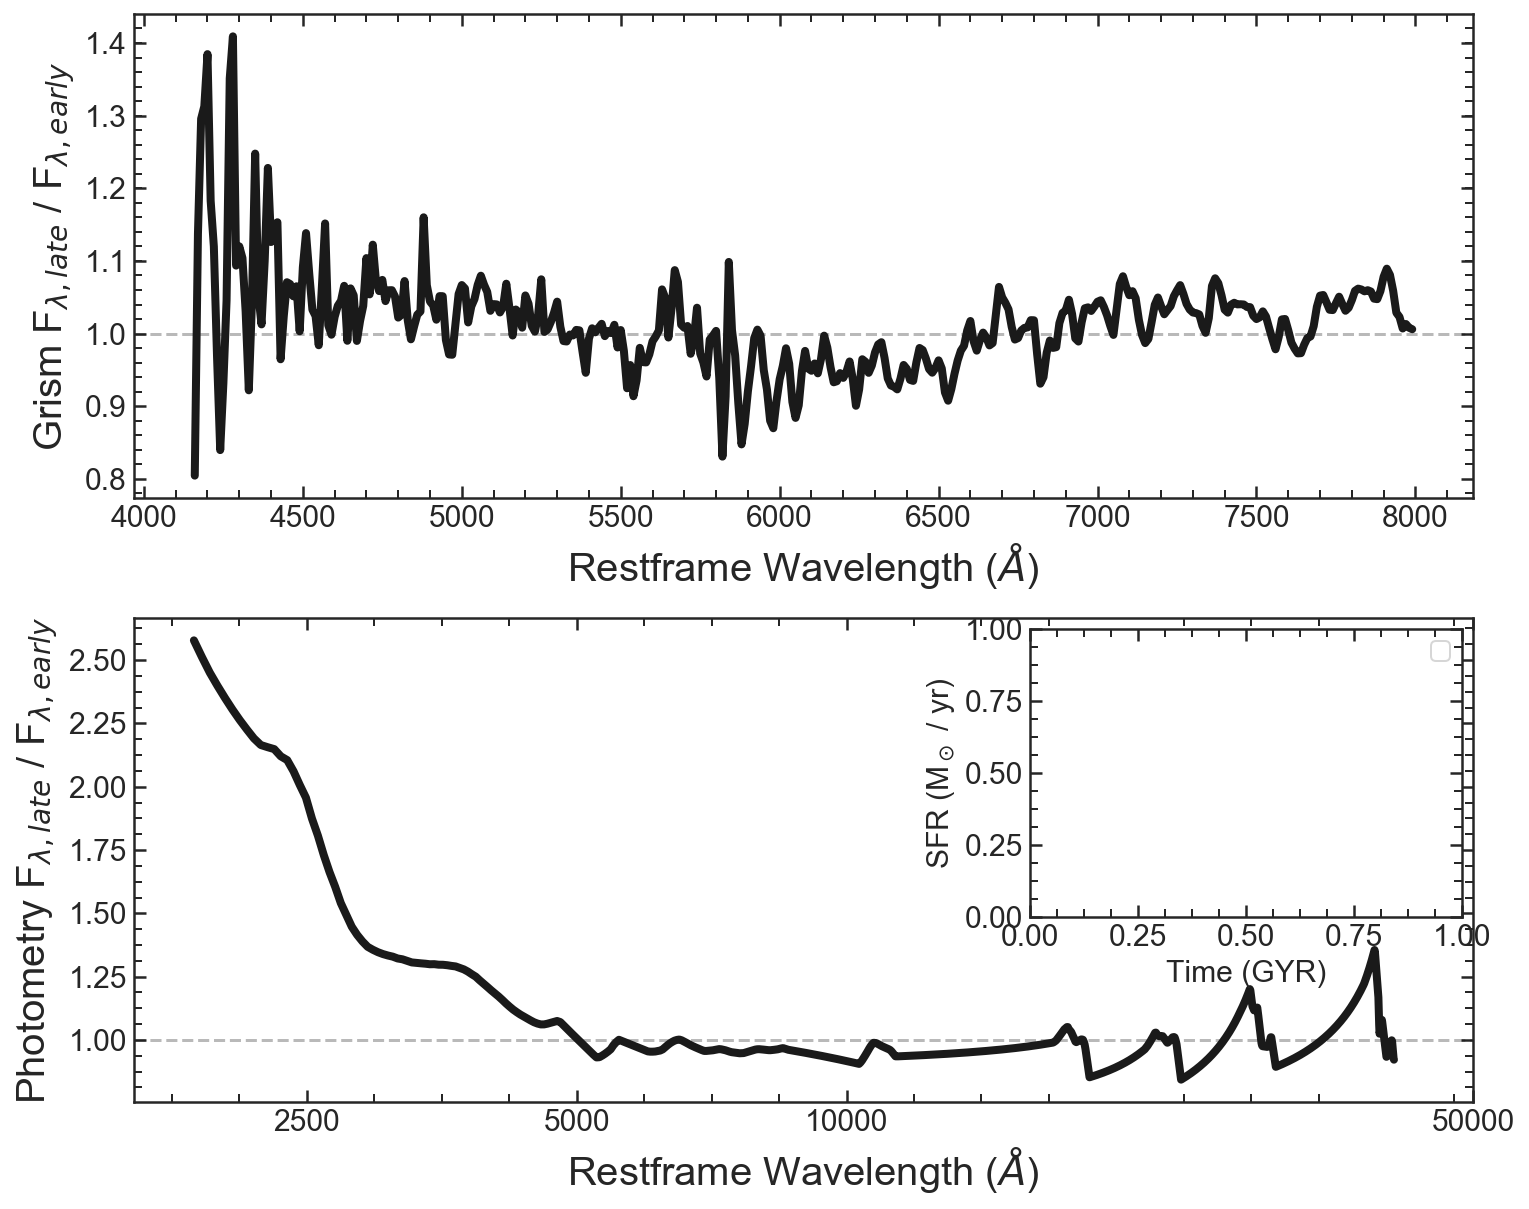

In [19]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

gs = gridspec.GridSpec(2,1,hspace=0.25,wspace=0.2)

plt.figure(figsize=[12,10])
plt.subplot(gs[0])
plt.plot(swave[swave > 4150], lzflux[swave > 4150] / hzflux[swave > 4150], 'k',linewidth = 4)

plt.xlabel('Restframe Wavelength ($\AA$)', fontsize=20)
plt.ylabel('Grism F$_{\lambda, late}$ / F$_{\lambda, early}$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.axhline(1, linestyle = '--', color = 'k', alpha = 0.3)
plt.minorticks_on()

ax1=plt.subplot(gs[1])

iwmn = np.linspace(1870,40800, 1000)
ipmn1 = interp1d(wmn1, Smooth(wmn1,pmn1,200))(iwmn)
ipmn2 = interp1d(wmn2, Smooth(wmn2,pmn2,200))(iwmn)

# plt.plot(np.log10(iwmn),np.log10(ipmn1 / ipmn2), linewidth = 4)
plt.plot(np.log10(iwmn),ipmn1 / ipmn2, 'k',linewidth = 4)

plt.axhline(1, linestyle = '--', color = 'k', alpha = 0.3)

plt.xlabel('Restframe Wavelength ($\AA$)', fontsize=20)
plt.ylabel('Photometry F$_{\lambda, late}$ / F$_{\lambda, early}$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.minorticks_on()
plt.xticks(np.log10([2500,5000,10000,50000]), [2500,5000,10000,50000])

axins = inset_axes(ax1, width=3, height=2)

# plt.plot(LBT[sfh_stack_lz > 0], sfh_stack_lz[sfh_stack_lz > 0], '#507678', linewidth = 3,label = 'z$_{50}$ < 3.4, 0.9 < z < 1.1')
# plt.plot(LBT[sfh_stack_hz > 0], sfh_stack_hz[sfh_stack_hz > 0], '#C4253C', linewidth = 3,label = 'z$_{50}$ > 3.4, 0.9 < z < 1.1')

plt.minorticks_on()

plt.xlabel('Time (GYR)', fontsize=15)
plt.ylabel('SFR (M$_\odot$ / yr)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=12)
# plt.savefig('../plots/presentation_plots/SFH_summary.pdf', bbox_inches = 'tight')

In [23]:

np.save('../data/plot_points/grism_ratio',[swave[swave > 4110], lzflux[swave > 4110] / hzflux[swave > 4110]])


np.save('../data/plot_points/phot_ratio',[np.log10(iwmn),ipmn1 / ipmn2])



# np.save('../data/plot_points/SFH1',[LBT[sfh_stack_lz > 0], sfh_stack_lz[sfh_stack_lz > 0]])
# np.save('../data/plot_points/SFH2',[LBT[sfh_stack_hz > 0], sfh_stack_hz[sfh_stack_hz > 0]])


In [257]:

lzmdb = mdb.query('z_50 < 3.26 and 0.9 < zgrism < 1.1')

hzmdb = mdb.query('z_50 > 3.26 and 0.9 < zgrism < 1.1')


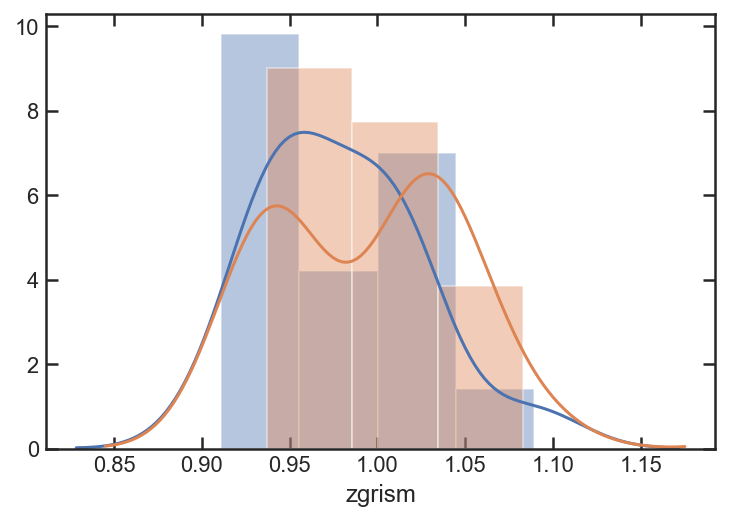

In [270]:
sea.distplot(lzmdb.zgrism)
sea.distplot(hzmdb.zgrism)

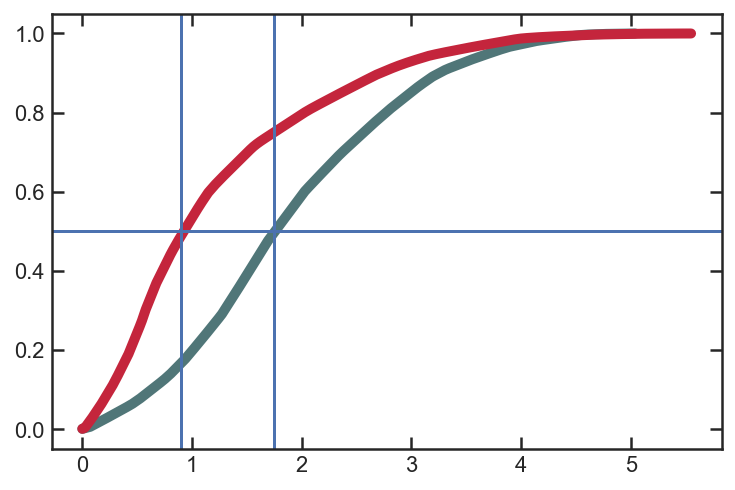

In [295]:
plt.subplot()
plt.plot(LBT[sfh_stack_lz > 0], 
         np.cumsum(sfh_stack_lz[sfh_stack_lz > 0][::-1]) / np.cumsum(sfh_stack_lz[sfh_stack_lz > 0][::-1])[-1],
         '#507678', linewidth = 5,label = 'z$_{50}$ < 3.3, 0.9 < z < 1.1')
plt.plot(LBT[sfh_stack_hz > 0], 
         np.cumsum(sfh_stack_hz[sfh_stack_hz > 0][::-1]) / np.cumsum(sfh_stack_hz[sfh_stack_hz > 0][::-1])[-1], 
         '#C4253C', linewidth = 5,label = 'z$_{50}$ > 3.3, 0.9 < z < 1.1')


plt.axhline(0.5)
plt.axvline(0.9)
plt.axvline(1.75)

In [289]:
LBT[sfh_stack_lz > 0]

array([0.00000000e+00, 1.00014288e-03, 2.00028576e-03, ...,
       5.03771967e+00, 5.03871982e+00, 5.03971996e+00])